In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## batch 表达方式
## batch = [word number, b ,wrod vec]
## batch = [b ,word number, wrod vec]

# 下载词袋模型

from torchnlp.word_to_vector import GloVe
vectors = GloVe()
vectors["hello"]

[torch.FloatTensor of size 100]

In [2]:
import  tushare as ts
# 获取代号为000300的股票价格
cons=ts.get_apis()
df1=ts.bar('000003', conn=cons, asset='INDEX', start_date='2018-01-01', end_date='')
df=df1.sort_index(ascending=True).astype(float)
df.head(10)

,code,open,close,high,low,vol,amount,p_change
datetime,,,,,,,,
2018-01-02,3.0,342.13,344.82,344.89,342.00,2490.0,177060672.0,NaN
2018-01-03,3.0,344.82,345.42,346.38,344.82,2782.0,212482704.0,0.17
2018-01-04,3.0,345.79,347.63,347.83,345.04,2492.0,169633072.0,0.64
2018-01-05,3.0,347.26,346.61,347.56,346.35,2565.0,184882096.0,-0.29
2018-01-08,3.0,346.83,348.03,348.50,346.79,3549.0,276297696.0,0.41
2018-01-09,3.0,348.04,347.19,348.55,346.68,1932.0,137042656.0,-0.24
2018-01-10,3.0,346.88,345.59,347.27,343.99,2611.0,186782560.0,-0.46
2018-01-11,3.0,344.96,345.15,345.23,343.61,2413.0,177811376.0,-0.13
2018-01-12,3.0,345.20,345.44,346.07,344.88,2486.0,178687904.0,0.08


In [3]:
def socke(num,start,end):
    df1=ts.bar(num, conn=cons, asset='INDEX', start_date=start, end_date=end)
    df=df1.sort_index(ascending=True)
    df.astype(float)
    print(df.head(10))
    print(df.columns)
    print(df.shape)
    df.to_csv('/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I5_algorithm/数据库文件/sh.csv')
    return df.to_numpy()[1:,1:]
df = socke("000010",'2010-01-01',"")

code      open     close      high       low       vol  \
datetime                                                               
2010-01-04  000010  7799.256  7666.876  7811.906  7666.406  480382.0   
2010-01-05  000010  7694.476  7748.256  7780.546  7591.416  613716.0   
2010-01-06  000010  7734.406  7685.766  7789.926  7684.166  544951.0   
2010-01-07  000010  7689.376  7534.626  7725.076  7495.656  568319.0   
2010-01-08  000010  7503.786  7552.986  7559.826  7441.036  434238.0   
2010-01-11  000010  7835.966  7573.996  7835.966  7539.476  669260.0   
2010-01-12  000010  7557.536  7678.756  7682.586  7468.636  678369.0   
2010-01-13  000010  7490.006  7404.476  7566.666  7394.136  831560.0   
2010-01-14  000010  7437.366  7500.606  7505.836  7380.286  578078.0   
2010-01-15  000010  7504.166  7524.856  7569.006  7452.536  505090.0   

                  amount  p_change  
datetime                            
2010-01-04  6.510389e+10       NaN  
2010-01-05  8.782037e+10      1.06  
2

In [4]:
x ,y = torch.FloatTensor(df[:,:-2].astype(float)),torch.FloatTensor(df[:,-1][:,None].astype(float))
x.shape,y.shape

(torch.Size([2576, 5]), torch.Size([2576, 1]))

In [5]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

num_time_steps = 5
input_size = 1
hidden_size = 16
output_size = 1
lr = 0.1

class Net(nn.Module):
    def __init__(self,):
        super(Net,self).__init__()
        self.rnn = nn.RNN(
            input_size = input_size # 1
            ,hidden_size = hidden_size #10
            ,num_layers = 1
            ,batch_first = True #[b,seq,feature]
        )
        for p in self.rnn.parameters():
            nn.init.normal_(p,mean=0.0,std=0.001)
        self.linear = nn.Linear(hidden_size,output_size) # AC: hidden_size => out_size | Chinge: dim == [n,1]
    
    def forward(self,x, hidden_prev):
        out ,hidden_prev = self.rnn(x,hidden_prev)
        #[1,seq,h]=>[seq,h]
        out = out.view(-1,hidden_size) #
        out = self.linear(out) # [seq,h] => [seq ,1]
        out = out.unsqueeze(dim = 0) #[1,seq,1]  because wewil be input it to MSE function ,so drop  it to one dim dim
        return out , hidden_prev


model = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr)
hidden_prev = torch.zeros(1,1,hidden_size)# [b,1,hidden_size=10]

for iter in range(6000):
    x = torch.tensor(x).float().view(2541,num_time_steps*5,1)
    y = torch.tensor(y).float().view(-1,num_time_steps-1,1)

    output , hidden_prev = model(x,hidden_prev)
    hidden_prev = hidden_prev.detach()

    loss = criterion(output,y)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    if iter % 100 == 0:
        print("Iteration:{} loss {}".format(iter,loss.item()))


RuntimeError: shape '[2541, 25, 1]' is invalid for input of size 12880

In [6]:
12705/7

1815.0

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [8]:
def generate_df_affect_by_n_days(series, n, index=False):
    if len(series) <= n:
        raise Exception("The Length of series is %d, while affect by (n=%d)." % (len(series), n))
    df = pd.DataFrame()
    for i in range(n):
        df['c%d' % i] = series.tolist()[i:-(n - i)]
    df['y'] = series.tolist()[n:]
    if index:
        df.index = series.index[n:]
    return df


def readData(column='high', n=30, all_too=True, index=False, train_end=-300):
    df = pd.read_csv("/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I5_algorithm/数据库文件/sh.csv", index_col=0).astype(float)
    df.index = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), df.index))
    df_column = df[column].copy()
    df_column_train, df_column_test = df_column[:train_end], df_column[train_end - n:]
    df_generate_from_df_column_train = generate_df_affect_by_n_days(df_column_train, n, index=index)
    if all_too:
        return df_generate_from_df_column_train, df_column, df.index.tolist()
    return df_generate_from_df_column_train


In [9]:
class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )
        self.out = nn.Sequential(
            nn.Linear(64, 1)
        )

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  # None 表示 hidden state 会用全0的 state
        out = self.out(r_out)
        return out


class TrainSet(Dataset):
    def __init__(self, data):
        # 定义好 image 的路径
        self.data, self.label = data[:, :-1].float(), data[:, -1].float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)


In [10]:
n = 300
LR = 0.001
EPOCH = 1000
train_end = -500


In [11]:
# 数据集建立
df, df_all, df_index = readData('high', n=n, train_end=train_end)

df_all = np.array(df_all.tolist())
#plt.plot(list(range(df_index)), df_all, label='real-data')

df_numpy = np.array(df)

df_numpy_mean = np.mean(df_numpy)
df_numpy_std = np.std(df_numpy)

df_numpy = (df_numpy - df_numpy_mean) / df_numpy_std
df_tensor = torch.Tensor(df_numpy)

trainset = TrainSet(df_tensor)
trainloader = DataLoader(trainset, batch_size=10, shuffle=True)


In [12]:
rnn = RNN(n)
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.MSELoss()

for step in range(EPOCH):
    for tx, ty in trainloader:
        #print(tx.shape,ty.shape)
        output = rnn(torch.unsqueeze(tx, dim=0))
        loss = loss_func(torch.squeeze(output), ty)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # back propagation, compute gradients
        optimizer.step()
    
    if step % 100:
        print(step, loss)
        print(tx.shape,ty.shape)
        torch.save(rnn, 'rnn.pkl')
torch.save(rnn, 'rnn.pkl')


grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
459 tensor(0.0016, grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
460 tensor(0.0024, grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
461 tensor(0.0026, grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
462 tensor(0.0015, grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
463 tensor(0.0007, grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
464 tensor(0.0010, grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
465 tensor(0.0028, grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
466 tensor(0.0023, grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
467 tensor(0.0042, grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
468 tensor(0.0015, grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
469 tensor(0.0017, grad_fn=<MseLossBackward>)
torch.Size([7, 300]) torch.Size([7])
470 tensor(0.0005, grad

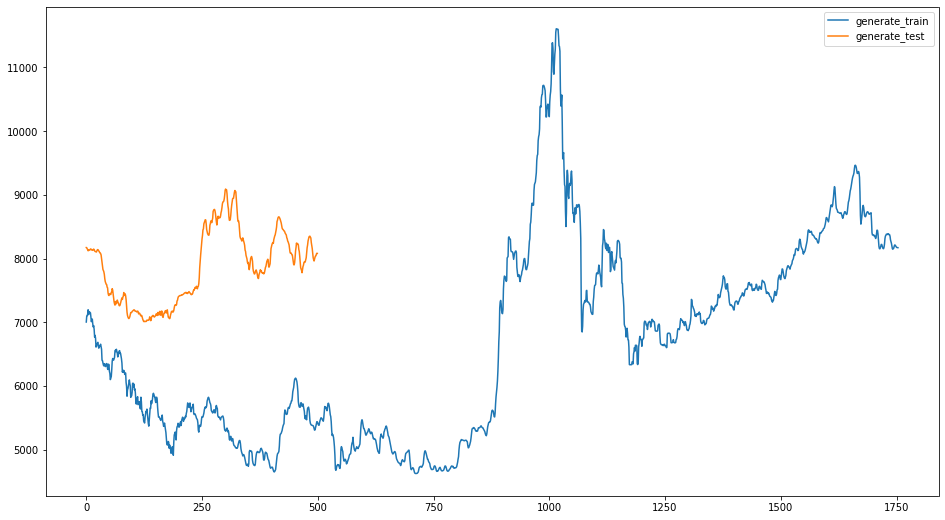

In [14]:

generate_data_train = []
generate_data_test = []

test_index = len(df_all) + train_end

df_all_normal = (df_all - df_numpy_mean) / df_numpy_std
df_all_normal_tensor = torch.Tensor(df_all_normal)
for i in range(n, len(df_all)):
    x = df_all_normal_tensor[i - n:i]
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=0)
    y = rnn(x)
    if i < test_index:
        generate_data_train.append(torch.squeeze(y).detach().numpy() * df_numpy_std + df_numpy_mean)
    else:
        generate_data_test.append(torch.squeeze(y).detach().numpy() * df_numpy_std + df_numpy_mean)
#print(df_index[n:train_end])
plt.figure(figsize=(16,9))
plt.plot(list(range(len(df_index[n:train_end]))), generate_data_train,label='generate_train')
plt.plot(list(range(len(df_index[train_end:])))
, generate_data_test
, label='generate_test')
plt.legend()
plt.show()
